# Sentiment analysis on amazon reviews

In this code along we're going to try to predict the rating of a product review based on the text content.

To this end, we will use the most simple approach ( bag of words ) with one tiny set of amazon reviews just for ilustrative purposes.

# Bag of words

The main problem is that sentences are not numbers and the ML models only uses numbers. Therefore we need to cast them into datasets in which every sentence will have several columns filled of values.

But wait..., how many columns? What they represent? ( in other words, what are going to mean the values in each column for each sentence )?

A first approach will be to assing a binnary value to every possible word in the sentence. However, as the vocabulary in every language is huge, the amount of columns will be also huge. We need to decrease the amount of columns. Then we need to find a way to determine which words we will keep and which don't.

### Reading reviews

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [3]:
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_csv("/content/drive/MyDrive/CURR-v3.X-MAR2023/UNIT8/DAY3/8.05 Natural Language Processing/amazon_reviews_us_Outdoors_v1_00.tsv.gz", 
                   compression = "gzip", error_bad_lines = False, sep = "\t")
data.head()

b'Skipping line 3121: expected 15 fields, saw 22\nSkipping line 23098: expected 15 fields, saw 22\nSkipping line 44261: expected 15 fields, saw 22\nSkipping line 46415: expected 15 fields, saw 22\nSkipping line 49691: expected 15 fields, saw 22\nSkipping line 53219: expected 15 fields, saw 22\n'
b'Skipping line 76042: expected 15 fields, saw 22\nSkipping line 94032: expected 15 fields, saw 22\nSkipping line 114699: expected 15 fields, saw 22\nSkipping line 125796: expected 15 fields, saw 22\n'
b'Skipping line 157739: expected 15 fields, saw 22\nSkipping line 175898: expected 15 fields, saw 22\nSkipping line 177167: expected 15 fields, saw 22\nSkipping line 192248: expected 15 fields, saw 22\n'
b'Skipping line 198940: expected 15 fields, saw 22\nSkipping line 216336: expected 15 fields, saw 22\nSkipping line 222360: expected 15 fields, saw 22\nSkipping line 230919: expected 15 fields, saw 22\nSkipping line 234929: expected 15 fields, saw 22\nSkipping line 254683: expected 15 fields, saw

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18446823,R35T75OLUGHL5C,B000NV6H94,110804376,Stearns Youth Boating Vest (50-90 lbs.),Outdoors,4,0.0,0.0,N,Y,Four Stars,GOOD VALUE,2015-08-31
1,US,13724367,R2BV735O46BN33,B000IN0W3Y,624096774,Primal Wear Men's Pink Floyd Dark Side of The ...,Outdoors,5,0.0,0.0,N,Y,Five Stars,Excellent quality.,2015-08-31
2,US,51001958,R2NBEUGPQQGXP1,B008RBJXFM,278970944,Osprey Hydraulics Reservoir,Outdoors,4,0.0,0.0,N,Y,Only Flaw Is The Cap,3rd season using it. I only fill with water an...,2015-08-31
3,US,32866903,R17LLAOJ8ITK0S,B00FK8WUQY,312877650,CamelBak eddy .75L Water Bottle,Outdoors,3,1.0,1.0,N,Y,Poor design leads to frequent mildew.,poor construction as mildew keeps forming in t...,2015-08-31
4,US,30907790,R39PEQBT5ISEF4,B00EZA3VW0,305567912,Children Black Red Striped Plastic Housing Ska...,Outdoors,1,0.0,0.0,N,Y,"Very bad quality, clips was broken when it arr...","Very bad quality, clips was broken when it arr...",2015-08-31


In [6]:
data.shape

(2299811, 15)

In [7]:
data = data[['review_id','review_body','helpful_votes','total_votes','verified_purchase','star_rating']]
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating
0,R35T75OLUGHL5C,GOOD VALUE,0.0,0.0,Y,4
1,R2BV735O46BN33,Excellent quality.,0.0,0.0,Y,5
2,R2NBEUGPQQGXP1,3rd season using it. I only fill with water an...,0.0,0.0,Y,4
3,R17LLAOJ8ITK0S,poor construction as mildew keeps forming in t...,1.0,1.0,Y,3
4,R39PEQBT5ISEF4,"Very bad quality, clips was broken when it arr...",0.0,0.0,Y,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299811 entries, 0 to 2299810
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   review_id          object 
 1   review_body        object 
 2   helpful_votes      float64
 3   total_votes        float64
 4   verified_purchase  object 
 5   star_rating        object 
dtypes: float64(2), object(4)
memory usage: 105.3+ MB


## Filtering reviews

We have around 2.3M of reviews but according to the data not all of them are "helpful". Let's do some filtering.

In [9]:
data['verified_purchase'].unique()

array(['Y', 'N', nan], dtype=object)

In [10]:
data = data[data['verified_purchase'] == 'Y']

In [11]:
data.shape

(2023594, 6)

200K unverified reviews droped.


In [12]:
data = data[data['helpful_votes'] > 0]

In [13]:
data.shape

(664625, 6)

Much better!

In [14]:
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating
3,R17LLAOJ8ITK0S,poor construction as mildew keeps forming in t...,1.0,1.0,Y,3
5,R3GNM3SU9VHJFT,Nice bag. Should have another strap on bottom ...,1.0,1.0,Y,4
7,R2LFGSI6HAYH5F,"Went on vacation in Lyme Disease country, kids...",1.0,1.0,Y,5
8,R297G6ED1IQO7W,Great item. Gets better after burn in. Used th...,1.0,1.0,Y,5
21,R2XYF9PCISPHE8,If 1/2&#34; is self inflating this is you're p...,1.0,1.0,Y,1


Let's check out the number of words in the first product review

In [16]:
data.iloc[0,1].split()

['poor',
 'construction',
 'as',
 'mildew',
 'keeps',
 'forming',
 'in',
 'the',
 'top',
 'cover.',
 'Needs',
 'frequent',
 'cleaning',
 'with',
 'brush',
 'into',
 'hard',
 'to',
 'reach',
 'areas.',
 'I',
 "wouldn't",
 'buy',
 'this',
 'kind',
 'again.']

In [15]:
len(data.iloc[0,1].split())

26

Let's get what is the percentage of usefull votes in each review

In [17]:
data['perc'] = list( map( lambda x, y: x/y, data['helpful_votes'], data['total_votes'] ) )

In [18]:
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating,perc
3,R17LLAOJ8ITK0S,poor construction as mildew keeps forming in t...,1.0,1.0,Y,3,1.0
5,R3GNM3SU9VHJFT,Nice bag. Should have another strap on bottom ...,1.0,1.0,Y,4,1.0
7,R2LFGSI6HAYH5F,"Went on vacation in Lyme Disease country, kids...",1.0,1.0,Y,5,1.0
8,R297G6ED1IQO7W,Great item. Gets better after burn in. Used th...,1.0,1.0,Y,5,1.0
21,R2XYF9PCISPHE8,If 1/2&#34; is self inflating this is you're p...,1.0,1.0,Y,1,1.0


In [19]:
data['helpful_votes'].describe()

count    664625.000000
mean          4.753988
std          18.846953
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2478.000000
Name: helpful_votes, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


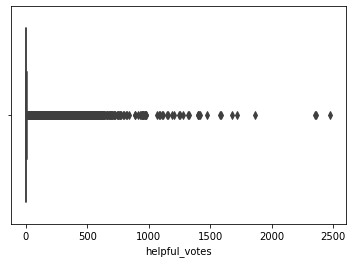

In [20]:
sns.boxplot(data['helpful_votes'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


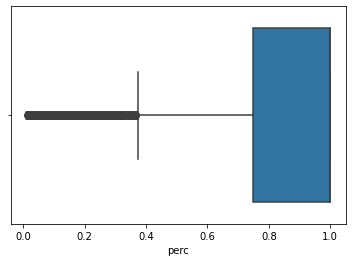

In [21]:
sns.boxplot(data['perc'])

In [22]:
data['perc'].describe()

count    664625.000000
mean          0.868096
std           0.212916
min           0.009302
25%           0.750000
50%           1.000000
75%           1.000000
max           1.000000
Name: perc, dtype: float64

Let's add afilter baser on the percentage of useful votes.

In [23]:
len(data[data['perc'] >= 0.75])

515835

In [24]:
data = data[data['perc'] >= 0.75]

In [25]:
data['helpful_votes'].value_counts()

1.0      237536
2.0       77217
3.0       53540
4.0       30487
5.0       19649
          ...  
526.0         1
698.0         1
813.0         1
913.0         1
802.0         1
Name: helpful_votes, Length: 555, dtype: int64

In [26]:
data['review_body']

3          poor construction as mildew keeps forming in t...
5          Nice bag. Should have another strap on bottom ...
7          Went on vacation in Lyme Disease country, kids...
8          Great item. Gets better after burn in. Used th...
21         If 1/2&#34; is self inflating this is you're p...
                                 ...                        
2299749    After searching for something decent in local ...
2299758    I purchased a [price] electric bagel cutter fo...
2299767    We bought the Pogo Stick as birthday gift for ...
2299779    When I first thought of getting the Firefly la...
2299798    This knife is awesome. It Swing out blade stor...
Name: review_body, Length: 515835, dtype: object

Now let's get the length of each review

In [27]:
data['length'] = list(map(lambda x: len(str(x).split()), data['review_body']))

In [28]:
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating,perc,length
3,R17LLAOJ8ITK0S,poor construction as mildew keeps forming in t...,1.0,1.0,Y,3,1.0,26
5,R3GNM3SU9VHJFT,Nice bag. Should have another strap on bottom ...,1.0,1.0,Y,4,1.0,60
7,R2LFGSI6HAYH5F,"Went on vacation in Lyme Disease country, kids...",1.0,1.0,Y,5,1.0,24
8,R297G6ED1IQO7W,Great item. Gets better after burn in. Used th...,1.0,1.0,Y,5,1.0,47
21,R2XYF9PCISPHE8,If 1/2&#34; is self inflating this is you're p...,1.0,1.0,Y,1,1.0,18


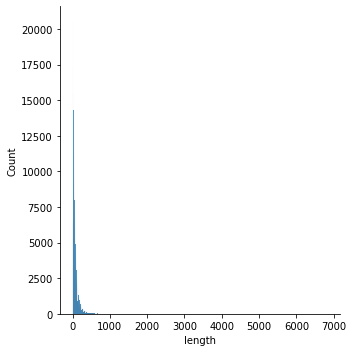

In [29]:
sns.displot(data['length'])

In [30]:
data['length'].describe()

count    515835.000000
mean         82.684686
std         108.880173
min           1.000000
25%          27.000000
50%          51.000000
75%          98.000000
max        6823.000000
Name: length, dtype: float64

In [31]:
m = data['length'].median()
m

51.0

Intuitivelly, we can consider short reviews as totally useless because they are not properly justified and they can misslead the model.

According to the median length, a reasonable guess will be to filter out reviews for which the length is smaller than the median.

In [32]:
data = data[data['length'] > m]
data.shape

(257453, 8)

In [33]:
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating,perc,length
5,R3GNM3SU9VHJFT,Nice bag. Should have another strap on bottom ...,1.0,1.0,Y,4,1.000000,60
22,RD10YF7LLTGCQ,This is my second time buying this system from...,1.0,1.0,Y,5,1.000000,79
27,R2FM18IYOYV53R,When I first bought these I was worried about ...,1.0,1.0,Y,4,1.000000,100
29,REU5E8A34P3R,I returned a pair of Roller Derby skates a bou...,5.0,5.0,Y,5,1.000000,301
65,R2FP3U4NHNFNL2,This item is awesome. It holds temp very well ...,25.0,29.0,Y,5,0.862069,284


### Merging reviews

Let's create first our "corpus" or database of "possible words" in the reviews. This is an specific set of common words in the reviews of this type of products.

In [37]:
reviews = ''

for review in data['review_body'].loc[:1000]:
    reviews += review

corpus = nltk.sent_tokenize(reviews)

In [38]:
corpus

['Nice bag.',
 'Should have another strap on bottom or something to hold it securely.',
 "Also, it doesn't say that is is waterproof, but I would like to verify for anyone who is wondering, it is NOT waterproof.",
 'it rained for about 10 minutes on a ride I was on, and the entire bag was saturated and everything in it soaked.This is my second time buying this system from RAD Cycle.',
 'It works very well, the price is reasonable, and opens up my garage floor.',
 "The only thing to be aware of is that the installation is not very hard, but will most likely require attaching it to a board, before it's attached to the ceiling.",
 "There is another option out there that comes with it's own board integrated in, which would make the installation just a little faster.When I first bought these I was worried about the 1 star rating a saying that the pedals started creaking when relatively new.",
 'I bought them anyway and am glad that I did.',
 'After about 100 of road use one of the pedals di

### Text cleaning

We would like to clean the text by means of:

* use lowercase
* drop punctuation marks

In [39]:
for i in range(len(corpus)):
    corpus[i] = corpus[i].lower()
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ',corpus[i]) # Replace one or more whitespaces by  ' '
    corpus[i] = re.sub(r'\d+',' ',corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", corpus[i]) # Replace e-mails by ''
    # Replace urls by ''
    corpus[i] = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , corpus[i]) 
    # Replace html tags by ''
    corpus[i] = BeautifulSoup(corpus[i], 'lxml').get_text().strip()

Let's see how big is our corpus.

In [40]:
print(len(corpus))

425


Let's take a sample review.

In [41]:
print(corpus[30])

drink stayed as cold as when i first poured


### Tokenizing the corpus

Now, what we want is to get how many times a word appears in the reviews: we want to count words. For that, we are going to use a dictionary in which the keys will be the words, and the values the corresponding frequencies of them

In [42]:
wordfreq = {} # A dictionary to hold as keys every single word, and the value is how many times appears the word.
for sentence in corpus:
    words = sentence.split() # List of words in a given review.
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ):
            wordfreq[word] = 1 # We initialize the corresponding counter
        else:
            wordfreq[word] += 1 # We increase the corresponding counter
    

Let's get how many words we have in our corpus.

In [43]:
len(list(wordfreq.keys()))

1911

This amount is insanely big to create a dataframe. Clearly, we need to reduce this. Let's pick only the most frequent words

### Reducing the corpus

There are two approaches for this:

* drop "stopwords" (articles, prepositions,...etc)
* use TF-IDF

In this notebook we are going to use first the "stopwords" approach

All the languages have some words which doesn't carry meaning, they are just to concatenate words. Those are typically articles, prepositions,...etc and therefore are useless for our pourposses. Then we would like to drop them. Fortunatelly the nltk library comes with a set of **stop words** for several languages although it's not perfect and you may want to tweek it a bit.

In [44]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Cleaning the stopwords

In [45]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])

#stop_words = [word for word in list(np.unique(stop_words)) if len(word) > 1]
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

Now let's drop the stop words and get how many times appear every non stopword in the whole dataset.

In [46]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [47]:
corpus

[(13, 'nice'),
 (7, 'bag'),
 (13, 'another'),
 (12, 'strap'),
 (8, 'bottom'),
 (10, 'something'),
 (16, 'hold'),
 (1, 'securely'),
 (19, 'also'),
 (8, 'say'),
 (2, 'waterproof'),
 (42, 'would'),
 (30, 'like'),
 (1, 'verify'),
 (4, 'anyone'),
 (1, 'wondering'),
 (1, 'rained'),
 (8, 'minutes'),
 (5, 'ride'),
 (1, 'entire'),
 (2, 'saturated'),
 (3, 'everything'),
 (3, 'soaked'),
 (5, 'second'),
 (21, 'time'),
 (3, 'buying'),
 (4, 'system'),
 (1, 'rad'),
 (1, 'cycle'),
 (4, 'works'),
 (28, 'well'),
 (11, 'price'),
 (1, 'reasonable'),
 (1, 'opens'),
 (2, 'garage'),
 (1, 'floor'),
 (4, 'thing'),
 (2, 'aware'),
 (6, 'installation'),
 (4, 'hard'),
 (1, 'likely'),
 (2, 'require'),
 (1, 'attaching'),
 (9, 'board'),
 (7, 'attached'),
 (1, 'ceiling'),
 (5, 'option'),
 (5, 'comes'),
 (1, 'integrated'),
 (9, 'make'),
 (9, 'little'),
 (1, 'faster'),
 (15, 'first'),
 (10, 'bought'),
 (1, 'worried'),
 (6, 'star'),
 (4, 'rating'),
 (2, 'saying'),
 (7, 'pedals'),
 (1, 'started'),
 (1, 'creaking'),
 (2, '

Let's sort the words by frequency and get the 20 most frequent words. We will use these "most frequent" words as the columns of our dataframe.
This value of 20 has to be chosen looking for a compromise between having a good accuracy and not too many columns in the dataset. Probably you would like to increase this value. However, for ilustrative purposes we're going to use this value.

Clearly the first word of the corpus doesn't make sense; we need to drop it.

In [48]:
corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
corpus_freq = [(word[1],word[0]) for word in corpus[:21]] 
corpus_freq = corpus_freq[1:] # The first word was not relevant
corpus_freq

[('tent', 46),
 ('would', 42),
 ('one', 39),
 ('bike', 39),
 ('great', 31),
 ('like', 30),
 ('well', 28),
 ('use', 28),
 ('pole', 22),
 ('get', 22),
 ('time', 21),
 ('easy', 20),
 ('also', 19),
 ('much', 18),
 ('light', 18),
 ('fit', 18),
 ('tool', 17),
 ('see', 17),
 ('really', 16),
 ('problem', 16)]

### Stemming

Let's use only the root of every word

> loved, love and lovers have the same root: love

we only want the "root" of each word.

Let's construct a list of tuples in which each tuple will contain the word and how many times appears the "root" of the word.



In [49]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [50]:
from nltk.stem import WordNetLemmatizer

lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[('tent', 46),
 ('would', 42),
 ('one', 39),
 ('bike', 39),
 ('great', 31),
 ('like', 30),
 ('well', 28),
 ('use', 28),
 ('pole', 22),
 ('get', 22),
 ('time', 21),
 ('easy', 20),
 ('also', 19),
 ('much', 18),
 ('light', 18),
 ('fit', 18),
 ('tool', 17),
 ('see', 17),
 ('really', 16),
 ('problem', 16)]

In [51]:
corpus_freq

[('tent', 46),
 ('would', 42),
 ('one', 39),
 ('bike', 39),
 ('great', 31),
 ('like', 30),
 ('well', 28),
 ('use', 28),
 ('pole', 22),
 ('get', 22),
 ('time', 21),
 ('easy', 20),
 ('also', 19),
 ('much', 18),
 ('light', 18),
 ('fit', 18),
 ('tool', 17),
 ('see', 17),
 ('really', 16),
 ('problem', 16)]

## Creating a dataframe 

Now we want to have a dataframe in which each column will correspond to each of the twenty most frequent words in the dataset while each record will contain how many times appears the corresponding word in the dataset. We can expand the number of columns considering more words, but in this case we will restrict ourselfs to this amount for instructive purposes.

In [52]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews

,tent,would,one,bike,great,like,well,use,pole,get,time,easy,also,much,light,fit,tool,see,really,problem


In [53]:
list(cols.keys())

['tent',
 'would',
 'one',
 'bike',
 'great',
 'like',
 'well',
 'use',
 'pole',
 'get',
 'time',
 'easy',
 'also',
 'much',
 'light',
 'fit',
 'tool',
 'see',
 'really',
 'problem']

Time to fill out the dataframe

In [ ]:
#import nltk
#nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
def add_integers(a: int, b: int) -> int:
    return a+b


add_integers("a",3)

The next cell will take roughly 12mins to complete!!!

In [54]:
def review_inpector(sentence, stop_words, words):
    '''
    Function that takes a review and returns a dictionary of word frequencies
    Inputs:
    sentence -> review: string
    stop_words -> list of stop_words
    words -> a list of words to count frequency 
    '''

    import re
    from nltk.stem import WordNetLemmatizer
    
    lem = WordNetLemmatizer()

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokens
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
    # Droping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

my_list = list( map(review_inpector, data['review_body'], 
                    [stop_words]*data.shape[0], [list(cols.keys())]*data.shape[0] ) )

my_list[:2]


[{'tent': 0,
  'would': 1,
  'one': 0,
  'bike': 0,
  'great': 0,
  'like': 1,
  'well': 0,
  'use': 0,
  'pole': 0,
  'get': 0,
  'time': 0,
  'easy': 0,
  'also': 1,
  'much': 0,
  'light': 0,
  'fit': 0,
  'tool': 0,
  'see': 0,
  'really': 0,
  'problem': 0},
 {'tent': 0,
  'would': 1,
  'one': 0,
  'bike': 0,
  'great': 0,
  'like': 0,
  'well': 1,
  'use': 0,
  'pole': 0,
  'get': 0,
  'time': 1,
  'easy': 0,
  'also': 0,
  'much': 0,
  'light': 0,
  'fit': 0,
  'tool': 0,
  'see': 0,
  'really': 0,
  'problem': 0}]

In [55]:
reviews = pd.DataFrame(my_list)

In [56]:
reviews.head()

,tent,would,one,bike,great,like,well,use,pole,get,time,easy,also,much,light,fit,tool,see,really,problem
0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,4,5,2,0,0,1,1,0,2,0,0,1,0,0,0,0
4,0,3,1,0,0,0,1,0,0,1,3,4,0,0,0,0,0,3,0,1


In [57]:
reviews['star_rating'] = data['star_rating']

In [58]:
data[['star_rating']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257453 entries, 5 to 2299779
Data columns (total 1 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   star_rating  257453 non-null  object
dtypes: object(1)
memory usage: 12.0+ MB


Let's inspect the number of star rating

In [59]:
reviews['star_rating'].value_counts()

5    7661
4    2743
5    2390
3    1318
1    1265
2     898
4     884
1     424
3     419
2     262
Name: star_rating, dtype: int64

Something weird happens here

In [60]:
reviews['star_rating'].unique()

array([nan, '4', '5', '3', '1', '2', 4, 5, 3, 1, 2], dtype=object)

In [61]:
reviews['star_rating'].isna().sum()

239189

In [62]:
reviews.dropna(inplace=True)

In [63]:
reviews.shape

(18264, 21)

In [64]:
reviews['star_rating'] = reviews['star_rating'].astype(str)

In [65]:
reviews['star_rating'].value_counts()

5    10051
4     3627
3     1737
1     1689
2     1160
Name: star_rating, dtype: int64

## Inspecting the number of stars

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


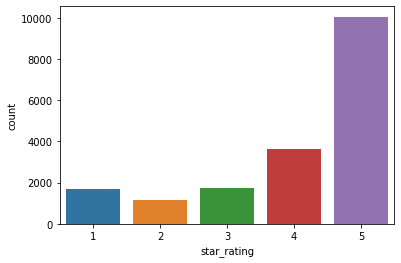

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.countplot(reviews['star_rating'],order = ['1','2','3','4','5']);

OMG huge imbalance!!!

This can be easily understood as people usually tend to rate only the good products unless they are really unhappy.

## Train test split

In [67]:
X = reviews.drop(columns='star_rating')
y = reviews['star_rating']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['star_rating'])
y_test  = pd.DataFrame(y_test, columns =['star_rating'])

Remember that the train test split respects the distribution of the dependent variable. Therefore we will still have the class imbalance in the train and test sets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


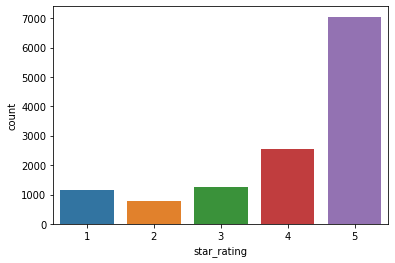

In [69]:
sns.countplot(y_train['star_rating'],order = ['1','2','3','4','5'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


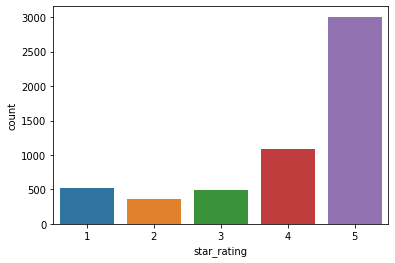

In [70]:
sns.countplot(y_test['star_rating'],order = ['1','2','3','4','5'])

As we saw yesterday, the train_test_split function preserves the distribution of the dependent feature

## Class balancing

Yesterday we saw how to perform downsampling manually. This time we are going to use a library to do the hard work for us: [imblearn](https://imbalanced-learn.org/)

In [71]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

X_train_res = pd.DataFrame(X_train_res, columns= X_train.columns)
y_train_res = pd.DataFrame(y_train_res, columns =['star_rating'])

Let's check the result!

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


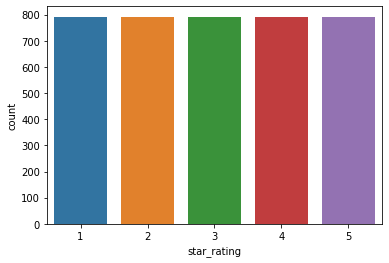

In [72]:
sns.countplot(y_train_res['star_rating'],order = ['1','2','3','4','5']);

In [73]:
y_train_res.value_counts()

star_rating
1              792
2              792
3              792
4              792
5              792
dtype: int64

## Naive Bayes Classification

Now we are ready to make calculations. We can use whatever method we want, but we will try to use the Naive Bayes Theorem.

This theorem is really easy to understand and to use. This theorem is about conditional probabilities: **what is the probability to find a result given something else is known?**

To fix ideas, let's consider only two features $x_{1}$ and $x_{2}$. We can ask what is the probability to find them together? ie

$$P(x_{1},x_{2}) = ?$$

As this can be complicated, we can split the process in two:

* compute the probability of finding one of the features values

* once we have the first one, compute the probability to find the second one, given the first

$$P(x_{1},x_{2}) = P(x_{1})*P(x_{2}|x_{1}) \tag{1}$$ 

where $P(x_{2}|x_{1})$ is the probability that having x_{1} finding x_{2}. 

We could also have started finding first $x_{2}$ and then, $x_{1}$. 

$$P(x_{1},x_{2}) = P(x_{2})*P(x_{1}|x_{2}) \tag{2}$$

The left hand side of equations (1) and (2) is the same, therefore, que can equal the right hand sides.

$$P(x_{1})*P(x_{2}|x_{1}) = P(x_{2})*P(x_{1}|x_{2})$$

Then we can isolate on of the both conditional probabilities:

$$P(x_{2}|x_{1})=\frac{P(x_{2})*P(x_{1}|x_{2})}{P(x_{1})}$$

or similarly:

$$P(x_{1}|x_{2})=\frac{P(x_{1})*P(x_{2}|x_{1})}{P(x_{2})}$$

which is the Bayes theorem. 

What is telling us? It tells us that if we want to compute a conditional probability which is difficult to compute, we can compute it using the conditional probability with the features in reverse order and the individual probabilitites.







What the Bayes Theorem has to do with review ratings? Easy, we can consider the independent features of our dataframe as one big feature: $X$ and the dependent feature ( rating ) as the other $R$. Then we want to compute what is the probability to obtain a given rating, given $X$. In other words, we are looking for $P(R|X)$. But now, we know the Bayes Theorem and we can compute this probability for every review as:

$$P(Y|X) = \frac{P(Y)*P(X|Y)}{P(X)}$$

Let's see how to compute each term:

$P(Y)$ is the probability of finding a given rating Y in our dataset: pretty easy!!! (number of reviews with a given rating out of total)

$P(X)$ is the probability to find a review with a given set of features: also pretty easy!!! (number of reviews with a given set of features out of total)

$P(X|Y)$ this is the probability of finding a given features in the review AMONG the ratings Y. In other words, within all the reviews with a given rating Y, how many of them have the given features out of total number of revires with rating R

So basically this is filtering and counting. Of course this method will not be too accurate if our sampling is poor. Let's give it a try anyway.

Caveat!

According to the Bayes Theorem, we need to divide by $P(X)$. This can become a problem if our dataset is too small, because then the probability of finding a review which has exactly the same values in the same columns can be null, and therefore the conditional probability will blow up. 

Let's write a function to do this for us.

In [74]:
def bayes(df, rating, review ): # rating = stars, review = X; P(R|X)
    '''
    This function will take a dataframe and it will return the most likely rating for
    a given review according to the Bayes Theorem
    '''
    df2 = df.copy()
    p_rating = len(df2[df2['star_rating'] == rating]) / len(df2)
    m = ((df2.iloc[:,:-1] == review).apply(sum, axis=1)).tolist()
    t = [index for index, value in enumerate(m) if value == 20]
    p_review = len(t) / len(df2)
    temp = df2[df2['star_rating'] == rating]
    m = ((df2[df2['star_rating'] == rating].iloc[:,:-1] == review).apply(sum, axis=1)).tolist()
    t = [index for index, value in enumerate(m) if value == 20]
    p_rating_review = len(t) / len(temp)
    p = ( p_rating * p_rating_review ) / p_review
    return round(p,2)

Let's use this function with the first review.

In [75]:
# Using a list comprehension to compute the probability of a given review to have
# a given rating
prob = [bayes(reviews, i, reviews.iloc[0,:-1].tolist()) for i in ['1','2','3','4','5']]
# Normalizing the probabilities
partition = np.sum(prob)
#partition
prob = [ ('Probability rating = ' + str(index+1),round(p/partition,2)) for index, p in enumerate(prob) ]
prob   

[('Probability rating = 1', 0.0),
 ('Probability rating = 2', 0.0),
 ('Probability rating = 3', 0.0),
 ('Probability rating = 4', 1.0),
 ('Probability rating = 5', 0.0)]

Now let's compare the prediction against the real value

In [76]:
reviews.iloc[0,-1]

'4'

Really good prediction! Probably we were really lucky.

In [77]:
y_train_res.shape
#y_train_res.reshape()

(3960, 1)

In [78]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

nb = CategoricalNB()
rf = RandomForestClassifier()

nb.fit(X_train_res, y_train_res['star_rating'])
rf.fit(X_train_res, y_train_res['star_rating'])

RandomForestClassifier()

## Making predictions

In [79]:
y_train_res_pred_rf = rf.predict(X_train_res)
y_test_pred_rf      = rf.predict(X_test)


## Model evaluation

In [80]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))


In [81]:
model_performance_class(y_train_res, y_train_res_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           1       0.86      0.85      0.85       792
           2       0.86      0.83      0.85       792
           3       0.84      0.84      0.84       792
           4       0.79      0.85      0.82       792
           5       0.87      0.84      0.85       792

    accuracy                           0.84      3960
   macro avg       0.84      0.84      0.84      3960
weighted avg       0.84      0.84      0.84      3960

Results obtained for the TEST SET
The Cohen's Kappa is: -0.01
              precision    recall  f1-score   support

           1       0.08      0.20      0.12       528
           2       0.06      0.17      0.09       368
           3       0.09      0.19      0.12       497
           4       0.20      0.22      0.21      1082
           5       0.51      0.18      0.26      3005

    accuracy                           0.19      5480
   macr

OMG!!! What happened here??? Any ideas?

* corpus
* range of ratings

# Proper way

## Defining a function to clean a review





In [82]:
def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'lxml').get_text().strip()
    x = x.replace(' br ',' ')

    return x


In [83]:
data.head()

,review_id,review_body,helpful_votes,total_votes,verified_purchase,star_rating,perc,length
5,R3GNM3SU9VHJFT,Nice bag. Should have another strap on bottom ...,1.0,1.0,Y,4,1.000000,60
22,RD10YF7LLTGCQ,This is my second time buying this system from...,1.0,1.0,Y,5,1.000000,79
27,R2FM18IYOYV53R,When I first bought these I was worried about ...,1.0,1.0,Y,4,1.000000,100
29,REU5E8A34P3R,I returned a pair of Roller Derby skates a bou...,5.0,5.0,Y,5,1.000000,301
65,R2FP3U4NHNFNL2,This item is awesome. It holds temp very well ...,25.0,29.0,Y,5,0.862069,284


In [84]:
reviews2 = data.copy()

In [85]:
reviews2 = reviews2[['review_body','star_rating']]

In [86]:
reviews2.head()

,review_body,star_rating
5,Nice bag. Should have another strap on bottom ...,4
22,This is my second time buying this system from...,5
27,When I first bought these I was worried about ...,4
29,I returned a pair of Roller Derby skates a bou...,5
65,This item is awesome. It holds temp very well ...,5


In [87]:
reviews2['review_body'] = reviews2['review_body'].apply(lambda x: clean_review(x)) 

In [88]:
reviews2.head()

,review_body,star_rating
5,nice bag should have another strap on bottom o...,4
22,this is my second time buying this system from...,5
27,when i first bought these i was worried about ...,4
29,i returned a pair of roller derby skates a bou...,5
65,this item is awesome it holds temp very well i...,5


# TF-IDF 

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words )

In [90]:
X = tidf.fit_transform(reviews2['review_body'])
y = reviews2['star_rating']

Let's inspect the features ie: the 2-grams used by the model ( the most frequent 2-grams )

In [91]:
tidf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa aaa',
 'aa batteries',
 'aa battery',
 'aaa batteries',
 'aaa battery',
 'abec bearings',
 'ability keep',
 'ability use',
 'able adjust',
 'able assemble',
 'able attach',
 'able bring',
 'able buy',
 'able carry',
 'able change',
 'able cut',
 'able easily',
 'able enjoy',
 'able figure',
 'able find',
 'able fit',
 'able fix',
 'able fold',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able install',
 'able keep',
 'able make',
 'able mount',
 'able move',
 'able open',
 'able pack',
 'able pull',
 'able put',
 'able quickly',
 'able reach',
 'able remove',
 'able return',
 'able ride',
 'able roll',
 'able run',
 'able see',
 'able set',
 'able sit',
 'able sleep',
 'able stand',
 'able stay',
 'able store',
 'able take',
 'able test',
 'able tighten',
 'able try',
 'able turn',
 'able use',
 'able walk',
 'able wear',
 'able zip',
 'absolutely amazing',
 'absolutely best',
 'absolutely buy',
 'absolutely fantastic',
 'absolutely great',
 'absolutely love',
 'absolu

In [92]:
len(tidf.get_feature_names())

20000

Now we can't see the features because the numpy array contains so many zero entries that is stores as "sparse matrix". An "sparse matrix" is one type of numpy array that contains so many zero entries that only stores in which columns contains non zero entries and what are the values there. 

In [93]:
X[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

## Train test split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# We don't convert the X_train, X_test back to df because they are spare_matrixes and we 
# don't know the column names anymore

In [95]:
type(X_train)

scipy.sparse.csr.csr_matrix

Unfortunatelly we can't use sparse matrixes with imblearn. Therefore we can't balance the dataset unless we do it manually. We will skip this for now as it was covered yesterday and we will apply a model stright ahead.

## Generating the model

In [96]:
from sklearn.ensemble import RandomForestClassifier

# We can go with lots of features because our dataset contains 20K!!!
rf = RandomForestClassifier(max_depth=100, n_estimators=50)

y_train = y_train.astype('int')
y_test  = y_test.astype('int')

rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

## Model evaluation

In [97]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.20
              precision    recall  f1-score   support

           1       0.96      0.27      0.42     12443
           2       0.99      0.11      0.20      9820
           3       1.00      0.08      0.14     16896
           4       0.91      0.16      0.27     40390
           5       0.60      1.00      0.75    100668

    accuracy                           0.63    180217
   macro avg       0.89      0.32      0.36    180217
weighted avg       0.75      0.63      0.53    180217

Results obtained for the TEST SET
The Cohen's Kappa is: 0.12
              precision    recall  f1-score   support

           1       0.63      0.18      0.28      5164
           2       0.66      0.02      0.04      4127
           3       0.82      0.01      0.03      7025
           4       0.65      0.10      0.18     17357
           5       0.59      0.99      0.74     43563

    accuracy                           0.60     77236
   macro

Its works really bad probably because several reasons:

* class imbalance
* too many combinations of words in 2-grams that we can't cover the relevant ones restricting ourselves to 20K features

Possible solutions:

* use nltk.tagger to tag each word
* keep only nouns and adjectives
* use 2-grams
* do class blancing



```
text = word_tokenize("And now for something completely different")
nltk.pos_tag(text)
[('And', 'CC'), ('now', 'RB'), ('for', 'IN'), ('something', 'NN'),
('completely', 'RB'), ('different', 'JJ')]
```



In [98]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [99]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN','VB'] ):
            words.extend(tag[0])
    return " ".join(words)

In [106]:
nltk.sent_tokenize("I like hiking. I don't like Mondays")

['I like hiking.', "I don't like Mondays"]